In [1]:
%matplotlib inline

In [2]:
#-------------------------------------------------------------------------------------------------------------------------------
# By Alexandra Lee (July 2018) 
#
# Generate input files
#
# Dataset: Pseudomonas aeruginosa gene expression compendium referenced in https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5069748/
# 
# Use map_file to group samples into phenotype groups (condition A and B) based on experimental design annotations
# Example: control vs treatment with antibiotics
# 
# Then group samples into training and test sets
#
# Generate offset vector using gene expression data in the original space (train_offset_original):
# average gene expression for condition A - average gene expression for condition B using all genes/dimensions
#-------------------------------------------------------------------------------------------------------------------------------
import os
import pandas as pd
import numpy as np
from scipy.stats import variation
import seaborn as sns
import matplotlib.pyplot as plt

randomState = 123
from numpy.random import seed
seed(randomState)

In [3]:
# load arguments
data_file = os.path.join(os.path.dirname(os.getcwd()), "data", "all-pseudomonas-gene-normalized.zip")
map_file = os.path.join(os.path.dirname(os.getcwd()), "metadata", "mapping_cipro.txt")

# output files
fig_file = os.path.join(os.path.dirname(os.getcwd()), "viz", "cipro_treatment", "cv.png")
train_control_file = os.path.join(os.path.dirname(os.getcwd()), "data", "cipro_treatment", "train_control.txt")
train_treat_file = os.path.join(os.path.dirname(os.getcwd()), "data", "cipro_treatment", "train_treat.txt")
test_control_file = os.path.join(os.path.dirname(os.getcwd()), "data", "cipro_treatment","test_control.txt")
test_treat_file = os.path.join(os.path.dirname(os.getcwd()), "data", "cipro_treatment", "test_treat.txt")
train_input_file = os.path.join(os.path.dirname(os.getcwd()), "data", "cipro_treatment", "train_model_input.txt.xz")
original_offset_file = os.path.join(os.path.dirname(os.getcwd()), "data", "cipro_treatment", "train_offset_original.txt")

In [4]:
# read in data
data = pd.read_table(data_file, header = 0, sep = '\t', index_col = 0, compression='zip')
X = data.transpose()
X.head(5)

Gene_symbol,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
0.1_12hr_CSV86(Pae_G1a).CEL,0.472897,0.396658,0.253776,0.000000,0.175640,0.554385,0.411370,0.382222,0.310144,0.642522,...,0.358597,0.390048,0.457406,0.684082,0.338351,0.608325,0.643496,0.276075,0.112773,0.145170
0.1_2hr_CSV86(Pae_G1a).CEL,0.262346,0.086216,0.359853,0.439214,0.269749,0.768433,0.212505,0.062043,0.567695,0.467073,...,0.358504,0.414206,0.389879,0.477693,0.000000,0.479385,0.154471,0.140891,0.167505,0.157060
0.1_6hr_CSV86(Pae_G1a).CEL,0.473658,0.244862,0.330750,0.097697,0.387226,0.328319,0.228820,0.330039,0.318081,0.512864,...,0.180744,0.380741,0.173501,0.251571,0.182793,0.528301,0.504985,0.499782,0.061106,0.365612
0.1_7hr_CSV86(Pae_G1a).CEL,0.439273,0.343402,0.192698,0.274677,0.628979,0.553796,0.431391,0.363480,0.385721,0.094584,...,0.346837,0.153927,0.067349,0.319723,0.282442,0.490655,0.531415,0.153880,0.132333,0.260087
0.1_9hr_CSV86(Pae_G1a).CEL,0.220827,0.145525,0.437803,0.293201,0.635120,0.462893,0.488733,0.309584,0.318646,0.591914,...,0.237726,0.301945,0.070222,0.513605,0.114277,0.360259,0.386868,0.223995,0.105343,0.102088


In [5]:
# read in metadata file containing grouping of each sample into training/test and phenotypic group
grp = pd.read_table(map_file, header=0, sep='\t', index_col=None)
grp

,Experiment ID,Sample ID,Group
0,E-GEOD-47173,GSM1146022_pJN105_1.CEL,control
1,E-GEOD-47173,GSM1146023_pJN105_2.CEL,control
2,E-GEOD-33871,GSM838212_PAO1-LB-1_Pae_G1a.CEL,control
3,E-GEOD-33871,GSM838213_PAO1-LB-2_Pae_G1a.CEL,control
4,E-GEOD-33871,GSM838214_PAO1-LB-3_Pae_G1a.CEL,control
5,E-GEOD-39044,GSM954576_Nomura_PA01-1_Pae_G1a_.CEL,control
6,E-GEOD-39044,GSM954577_Nomura_PA01-2_Pae_G1a_.CEL,control
7,E-GEOD-39044,GSM954578_Nomura_PA01-3_Pae_G1a_.CEL,control
8,E-GEOD-39044,GSM954579_Nomura_PA01-4_Pae_G1a_.CEL,control
9,E-GEOD-33244,GSM822708_wtLB_A.CEL,control


In [6]:
# Group samples into condition A and B based on mapping file provided
control_all = pd.DataFrame()
treat_all = pd.DataFrame()

for index, row in grp.iterrows():
    if row['Group'] == 'control':
        sample = str(row['Sample ID'])
        control_all = control_all.append(X[X.index.str.contains(sample, regex=False)])
        #print('Training group A {}'.format(sample))
    else:
        sample = str(row['Sample ID'])
        treat_all = treat_all.append(X[X.index.str.contains(sample, regex=False)])
        #print('Training group B {}'.format(sample))

# Split 10% test set randomly
test_set_percent = 0.2
test_control = control_all.sample(frac=test_set_percent, random_state = randomState)
train_control = control_all.drop(test_control.index)

test_treat = treat_all.sample(frac=test_set_percent, random_state = randomState)
train_treat = treat_all.drop(test_treat.index)

#control_all
train_treat
#test_treat

Gene_symbol,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
GSM1608067_Biofilm+12hrcipro_rep1.CEL,0.349389,0.413949,0.250081,0.377690,0.122332,0.142240,0.249760,0.235515,0.305095,0.242721,...,0.182157,0.363448,0.334562,0.546361,0.519035,0.665411,0.580959,0.482712,0.427450,0.334655
GSM1608068_Biofilm+12hrcipro_rep2.CEL,0.702616,0.575372,0.398821,0.578975,0.206532,0.269258,0.386129,0.386773,0.506036,0.172577,...,0.390245,0.424502,0.625507,0.591859,0.691683,0.382980,0.411006,0.526612,0.641058,0.519968
GSM1608069_Biofilm+12hrcipro_rep3.CEL,0.292754,0.331822,0.269647,0.269769,0.238973,0.251568,0.179758,0.342636,0.337006,0.129300,...,0.191975,0.410978,0.392039,0.454901,0.497975,0.551738,0.477691,0.465171,0.389111,0.186041
GSM1244967_PAO1-22-replicate-01.CEL,0.724677,0.646238,0.543188,0.602817,0.129240,0.445718,0.448800,0.374090,0.460794,0.186789,...,0.762616,0.262456,0.675094,0.310579,0.354925,0.236262,0.146266,0.194486,0.368172,0.723578
GSM1244969_PAO1-22-replicate-03.CEL,0.688311,0.642617,0.509997,0.565240,0.189924,0.528144,0.437972,0.412447,0.443915,0.224253,...,0.723298,0.246791,0.676931,0.300679,0.343358,0.148124,0.198693,0.212573,0.379110,0.720312
GSM1244970_PAO1-37-replicate-01.CEL,0.658872,0.633360,0.525580,0.572339,0.399227,0.658371,0.525074,0.541896,0.453016,0.226392,...,0.725490,0.368848,0.663369,0.476622,0.567851,0.182775,0.153126,0.219046,0.642666,0.931118
GSM1244972_PAO1-37-replicate-03.CEL,0.671477,0.686324,0.496537,0.578135,0.329976,0.620093,0.551462,0.537220,0.340387,0.237050,...,0.698331,0.341835,0.637240,0.467074,0.525419,0.262677,0.088298,0.213649,0.636263,0.930871
GSM900177_F1_Pae_G1a_.CEL,0.324767,0.552577,0.353925,0.854656,0.286250,0.420551,0.551583,0.494305,0.307261,0.189964,...,0.304239,0.347560,0.207912,0.549049,0.898524,0.440766,0.865415,0.470027,0.482156,0.505142
GSM900179_F2_Pae_G1a_.CEL,0.464562,0.578245,0.364953,0.698992,0.138776,0.491996,0.526017,0.480416,0.468245,0.279589,...,0.255819,0.535320,0.307848,0.595116,0.879332,0.336669,0.829124,0.366386,0.481790,0.468539
GSM900180_C2_Pae_G1a_.CEL,0.300984,0.506320,0.235985,0.763346,0.128667,0.464545,0.703223,0.523468,0.341234,0.188779,...,0.228775,0.544497,0.163744,0.532704,0.857999,0.357080,0.826668,0.404711,0.452079,0.448463


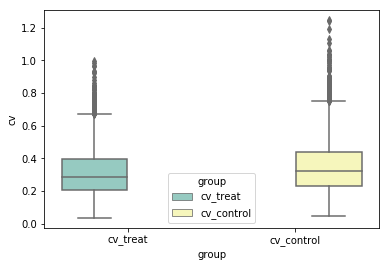

In [7]:
# Calculate Coefficient of Variance (CV) to determine variance between samples
# CV is the standardized measure of dispersion from the mean
treat_cv = variation(treat_all, axis = 0)
treat_cv = pd.DataFrame(treat_cv, columns = ['cv_treat'])
treat_cv.insert(0, 'gene_id', treat_all.columns)

control_cv = variation(control_all, axis = 0)
control_cv = pd.DataFrame(control_cv, columns = ['cv_control'])
control_cv.insert(0, 'gene_id', control_all.columns)

# Join 
CV = pd.merge(treat_cv, control_cv, on = 'gene_id')
CV = pd.melt(CV, id_vars = 'gene_id', var_name = 'group', value_name = 'cv' )
CV.head(5)

# figure
fig = plt.figure()
fg = sns.boxplot(x = 'group', y='cv', hue='group',  data=CV, palette="Set3")
fig.savefig(fig_file)

In [8]:
# Create input holding out test test
input_holdout = X.drop(test_control.index)
input_holdout = input_holdout.drop(test_treat.index)

input_holdout.head(5)
input_holdout.shape
#X.shape

(1183, 5549)

In [9]:
# Average gene expression across samples in training set
train_control_mean = train_control.mean(axis=0)
train_treat_mean = train_treat.mean(axis=0)

# Generate offset using average gene expression in original dataset
train_offset_original = train_treat_mean - train_control_mean
train_offset_original_df = pd.Series.to_frame(train_offset_original).transpose()
train_offset_original_df

Gene_symbol,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
0,-0.099782,-0.121703,-0.037494,-0.043734,-0.216924,0.072742,0.082047,-0.161538,-0.160335,0.014055,...,0.059468,-0.17019,-0.124185,-0.108054,0.036396,0.100216,-0.005987,-0.147975,-0.177429,-0.075753


In [10]:
# Output
train_control.to_csv(train_control_file, sep='\t')
train_treat.to_csv(train_treat_file, sep='\t')

test_control.to_csv(test_control_file, sep='\t')
test_treat.to_csv(test_treat_file, sep='\t')

train_offset_original_df.to_csv(original_offset_file, sep='\t')

input_holdout.to_csv(train_input_file, sep='\t', compression='xz')